In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import string
import tensorflow as tf
import re
import os
import time
from rouge import Rouge
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [5]:
ENCODER_LEN = 140
DECODER_LEN = 40
BATCH_SIZE = 64
BUFFER_SIZE = BATCH_SIZE*8  #ensure that the data is shuffled to avoid bias during training.

In [8]:
# Assuming the file paths are provided for training, validation, and testing datasets
train_path = "samsum-train.csv"
val_path = "samsum-validation.csv"
test_path = "samsum-test.csv"

# Load datasets
train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

# Preprocessing function
def preprocess_text(text):
    text = text.lower().strip()  # Example: lowercase and strip whitespace
    text = re.sub(r"&.[1-9]+;"," ",text)
    return f"<SOS> {text} <EOS>"

# Drop rows with missing values
train_data = train_data.dropna(subset=['dialogue', 'summary']).copy()
val_data = val_data.dropna(subset=['dialogue', 'summary']).copy()
test_data = test_data.dropna(subset=['dialogue', 'summary']).copy()

# Preprocess datasets
train_data['dialogue'] = train_data['dialogue'].apply(preprocess_text)
train_data['summary'] = train_data['summary'].apply(preprocess_text)

val_data['dialogue'] = val_data['dialogue'].apply(preprocess_text)
val_data['summary'] = val_data['summary'].apply(preprocess_text)

test_data['dialogue'] = test_data['dialogue'].apply(preprocess_text)
test_data['summary'] = test_data['summary'].apply(preprocess_text)

# Tokenization
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'
dialogue_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_token)
summary_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)

#train
dialogue_tokenizer.fit_on_texts(train_data['dialogue'].tolist())
summary_tokenizer.fit_on_texts(train_data['summary'].tolist())
inputs = dialogue_tokenizer.texts_to_sequences(train_data['dialogue'].tolist())
targets = summary_tokenizer.texts_to_sequences(train_data['summary'].tolist())

#validation
val_inputs = dialogue_tokenizer.texts_to_sequences(val_data['dialogue'].tolist())
val_targets = summary_tokenizer.texts_to_sequences(val_data['summary'].tolist())

#test

test_inputs = dialogue_tokenizer.texts_to_sequences(test_data['dialogue'].tolist())
test_targets = summary_tokenizer.texts_to_sequences(test_data['summary'].tolist())


In [9]:
ENCODER_VOCAB = len(dialogue_tokenizer.word_index) + 1  #tokenizer's index start from 1
DECODER_VOCAB = len(summary_tokenizer.word_index) + 1
print(ENCODER_VOCAB, DECODER_VOCAB)

38360 17603


In [10]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=ENCODER_LEN, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=DECODER_LEN, padding='post', truncating='post')

val_inputs = tf.keras.preprocessing.sequence.pad_sequences(val_inputs, maxlen=ENCODER_LEN, padding='post', truncating='post')
val_targets = tf.keras.preprocessing.sequence.pad_sequences(val_targets, maxlen=DECODER_LEN, padding='post', truncating='post')

test_inputs = tf.keras.preprocessing.sequence.pad_sequences(test_inputs, maxlen=ENCODER_LEN, padding='post', truncating='post')
test_targets = tf.keras.preprocessing.sequence.pad_sequences(test_targets, maxlen=DECODER_LEN, padding='post', truncating='post')

inputs = tf.cast(inputs, dtype=tf.int64)  #u may use int32
targets = tf.cast(targets, dtype=tf.int64)

val_inputs = tf.cast(val_inputs, dtype=tf.int64)
val_targets = tf.cast(val_targets, dtype=tf.int64)

test_inputs = tf.cast(test_inputs, dtype=tf.int64)
test_targets = tf.cast(test_targets, dtype=tf.int64)


In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_inputs, val_targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [12]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [13]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])


In [14]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output,training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2


class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output,training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [15]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)

        return x

class Decoder(tf.keras.layers.Layer):

    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training=training,look_ahead_mask=look_ahead_mask,padding_mask=padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        return x, attention_weights

In [16]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        # Pass enc_padding_mask as a keyword argument to the encoder
        enc_output = self.encoder(inp, training=training, mask=enc_padding_mask)

        # Pass enc_output as a keyword argument to the decoder
        dec_output, attention_weights = self.decoder(tar, enc_output=enc_output, training=training,
            look_ahead_mask=look_ahead_mask,padding_mask=dec_padding_mask )

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights


Learning Rate:  <__main__.CustomSchedule object at 0x7eb998568d30>


Text(0.5, 0, 'Train Step')

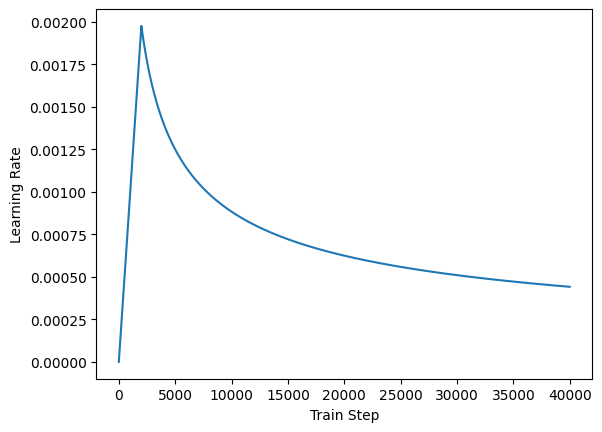

In [17]:
num_layers = 6
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.3
EPOCHS = 20

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=2000):  #4000 by default
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Ensure step is a float

        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
print("Learning Rate: ",learning_rate)

temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [18]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    #accuracies = tf.cast(accuracies, dtype= tf.float32)

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [19]:

# Define metrics for training and validation
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.Mean(name='val_accuracy')

In [20]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=ENCODER_VOCAB,
    target_vocab_size=DECODER_VOCAB,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [21]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [22]:
checkpoint_path = "checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [23]:
@tf.function
def val_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    predictions, _ = transformer(
        inp=inp,
        tar=tar_inp,
        training=False,  # Validation mode
        enc_padding_mask=enc_padding_mask,
        look_ahead_mask=combined_mask,
        dec_padding_mask=dec_padding_mask,
    )
    loss = loss_function(tar_real, predictions)

    val_loss(loss)
    val_accuracy(accuracy_function(tar_real, predictions))


In [24]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp=inp,
            tar=tar_inp,
            training=True,  # Pass explicitly as a keyword argument
            enc_padding_mask=enc_padding_mask,
            look_ahead_mask=combined_mask,
            dec_padding_mask=dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)
    gradients = tape.gradient(loss, transformer.trainable_variables)

    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

def debug_model(transformer):
    print(transformer.summary())
    encoder_weights = transformer.encoder.get_weights()
    decoder_weights = transformer.decoder.get_weights()

    if encoder_weights:  # Check if weights are not empty
        print("encoder Weights:", encoder_weights[0])
    else:
        print("No weights available in the encoder.")

    if decoder_weights:  # Check if weights are not empty
        print("decoder Weights:", encoder_weights[0])
    else:
        print("No weights available in the decoder.")



In [25]:
for epoch in range(EPOCHS):
    train_loss.reset_state()
    train_accuracy.reset_state()
    val_loss.reset_state()
    val_accuracy.reset_state()

    # Training loop
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        if batch % 100 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

    # Validation loop
    for (batch, (inp, tar)) in enumerate(val_dataset):
        val_step(inp, tar)
        if batch % 100 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))


    print(f"Epoch {epoch+1}, "
          f"Train Loss: {train_loss.result():.4f}, Train Accuracy: {train_accuracy.result():.4f}, "
          f"Val Loss: {val_loss.result():.4f}, Val Accuracy: {val_accuracy.result():.4f}")


Epoch 1 Batch 0 Loss 9.7760 Accuracy 0.0000
Epoch 1 Batch 100 Loss 9.5246 Accuracy 0.0342
Epoch 1 Batch 200 Loss 8.9129 Accuracy 0.0392
Epoch 1 Batch 0 Loss 8.7034 Accuracy 0.0399
Epoch 1, Train Loss: 8.7034, Train Accuracy: 0.0399, Val Loss: 7.0618, Val Accuracy: 0.0447
Epoch 2 Batch 0 Loss 7.2076 Accuracy 0.0437
Epoch 2 Batch 100 Loss 6.8736 Accuracy 0.0446
Epoch 2 Batch 200 Loss 6.8239 Accuracy 0.0477
Epoch 2 Batch 0 Loss 6.8103 Accuracy 0.0495
Epoch 2, Train Loss: 6.8103, Train Accuracy: 0.0495, Val Loss: 6.7662, Val Accuracy: 0.0600
Epoch 3 Batch 0 Loss 6.7704 Accuracy 0.0608
Epoch 3 Batch 100 Loss 6.7030 Accuracy 0.0641
Epoch 3 Batch 200 Loss 6.6475 Accuracy 0.0664
Epoch 3 Batch 0 Loss 6.6277 Accuracy 0.0681
Epoch 3, Train Loss: 6.6277, Train Accuracy: 0.0681, Val Loss: 6.5731, Val Accuracy: 0.0820
Epoch 4 Batch 0 Loss 6.5657 Accuracy 0.0752
Epoch 4 Batch 100 Loss 6.3406 Accuracy 0.0916
Epoch 4 Batch 200 Loss 6.2455 Accuracy 0.0967
Epoch 4 Batch 0 Loss 6.2188 Accuracy 0.0983
Epoc

In [ ]:
def evaluate(preprocessed_input):
    """
    Generate a summary for the given preprocessed input.

    Args:
    - preprocessed_input: Tokenized and padded input (shape: [ENCODER_LEN]).

    Returns:
    - output: Generated token sequence (without batch dimension).
    - attention_weights: Attention weights from the Transformer.
    """
    # Add batch dimension to the encoder input
    encoder_input = tf.expand_dims(preprocessed_input, 0)

    # Initialize the decoder input with the <sos> token
    decoder_input = [summary_tokenizer.word_index['<sos>']]
    output = tf.expand_dims(decoder_input, 0)  # Add batch dimension

    for i in range(DECODER_LEN):
        # Create masks for Transformer
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output
        )

        # Get predictions from the Transformer
        predictions, attention_weights = transformer(
            inp=encoder_input,
            tar=output,
            training=False,  # Inference mode
            enc_padding_mask=enc_padding_mask,
            look_ahead_mask=combined_mask,
            dec_padding_mask=dec_padding_mask,
        )

        # Extract the last prediction
        predictions = predictions[:, -1:, :]  # Shape: (batch_size, 1, vocab_size)
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # Stop decoding if <eos> token is predicted
        if predicted_id == summary_tokenizer.word_index['<eos>']:
            return tf.squeeze(output, axis=0), attention_weights

        # Append the predicted token to the output sequence
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights


def summarize(preprocessed_input):
    """
    Generate a human-readable summary from the given preprocessed input.

    Args:
    - preprocessed_input: Tokenized and padded input.

    Returns:
    - summary: Generated summary as a string.
    """
    # Get the evaluated output (token sequence)
    summarized = evaluate(preprocessed_input=preprocessed_input)[0].numpy()

    # Remove the <SOS> token and prepare for decoding
    summarized = np.expand_dims(summarized[1:], 0)  # Remove <sos> token

    # Convert tokens to text
    summary = summary_tokenizer.sequences_to_texts(summarized)[0]
    # Debug: Print the decoded summary
    print("Decoded Summary:", summary)
    return summary


rouge = Rouge()

def test_model(test_inputs, test_targets, summary_tokenizer):
    """
    Evaluate the model on preprocessed test inputs and calculate ROUGE scores.

    Args:
    - test_inputs: Preprocessed and padded dialogue inputs (numerical tokens).
    - test_targets: Original summaries for the dialogues (raw text).
    - summary_tokenizer: Tokenizer for decoding generated summaries.

    Returns:
    - scores: Dictionary of average ROUGE scores.
    """
    generated_summaries = []
    reference_summaries = []

    # Iterate through the test set
    for i in range(len(test_inputs)):
        input_article = test_inputs[i]  # Preprocessed dialogue
        reference_summary = test_targets[i]  # Original summary

        # Generate a summary
        generated_summary = summarize(preprocessed_input=input_article)

        # Append summaries
        generated_summaries.append(generated_summary)
        reference_summaries.append(reference_summary)

        # Optionally print progress
        if i % 10 == 0:  # Print every 10 samples
            print(f"Processed {i}/{len(test_inputs)} examples.")

    # Compute ROUGE scores
    scores = rouge.get_scores(generated_summaries, reference_summaries, avg=True)

    # Print results
    print("ROUGE Scores:")
    print(f"ROUGE-1: {scores['rouge-1']}")
    print(f"ROUGE-2: {scores['rouge-2']}")
    print(f"ROUGE-L: {scores['rouge-l']}")

    return scores


# Test the model using preprocessed test_inputs and test_targets
test_scores = test_model(
    test_inputs=test_inputs.numpy(),
    test_targets=test_data['summary'].tolist(),
    summary_tokenizer=summary_tokenizer,
)


Decoded Summary: lisa is angry with her phone
Processed 0/819 examples.
Decoded Summary: the team is not satisfied with the team
Decoded Summary: tom is angry with his phone
Decoded Summary: lisa will come to the party at home
Decoded Summary: jenny is going to visit her parents for a week
Decoded Summary: tom and tom will go to the cinema to the cinema to the concert at the weekend
Decoded Summary: tom is angry with her cat
Decoded Summary: the teacher is going to the doctor tomorrow
Decoded Summary: the team is going to the vet tomorrow
Decoded Summary: jessica is going to the party tomorrow and she will come to the party
Decoded Summary: lisa will come to the party tomorrow
Processed 10/819 examples.
Decoded Summary: jeff and tom are going to play game in the game they will play game in the game
Decoded Summary: the team is not satisfied with the game
Decoded Summary: tom and tom will meet at the entrance
Decoded Summary: the team is not satisfied with the new neighbor
Decoded Summa